# Assignment 1.2

## 1. Build the network

In [4]:
import re
import requests
import json
import os

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

Open .txt file copied from wikipedia page where links that did not correspond to music artists were removed.

In [33]:
with open("wikipage.txt", "r", encoding="utf-8") as f:
        wiki_text = f.read()

match_wiki = re.findall(r'\[\[(.*?)\]\]', wiki_text) 
print("Length of match_wiki list: ", len(match_wiki))
print("Match_wiki example element: ", match_wiki[1])

Length of match_wiki list:  488
Match_wiki example element:  10 Years (band)|10 Years


Clean artists names for next task:
- remove | and characters that come next;
- keep everything else the same so we can use this list to acess wikipedia again when creating a .txt file for each artist.

In [35]:
match_wiki_clean=[]
for m in match_wiki:
    short_m = m.split('|')[0]
    match_wiki_clean.append(short_m)

print("Match_wiki and match_wiki_clean have same kength: ", len(match_wiki_clean) == len(match_wiki))

Match_wiki and match_wiki_clean have same kength:  True


Create a .txt file for each artist:
- In Shakin Stevens wikipedia page The Rolling Stones appear as "the Rolling Stones" so files are saved in lowercase.

In [ ]:
baseurl = "https://en.wikipedia.org/w/api.php?"
action = "action=query"
content = "prop=revisions&rvprop=content"
dataformat ="format=json"
rvslots = "rvslots=main"
headers = {"User-Agent" : "MyWikipediaClient/1.0 (example@example.com)"} # just use this dict as-is.

folder_name = "artist_texts"
os.makedirs(folder_name, exist_ok=True)

for m in match_wiki_clean:
    title = "titles=" + m
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat, rvslots)
    
    wikiresponse = requests.get(query, headers=headers)
    wikidata = wikiresponse.text
    dict_data=json.loads(wikidata)

    key_number=list(dict_data['query']['pages'].keys())[0]
    page = dict_data['query']['pages'][str(key_number)]

    if 'revisions' in page and len(page['revisions']) > 0:
        wiki_text = page['revisions'][0].get('*', '')
    else:
        wiki_text = ''
        print("No revisions found for artist " + m)

    #for AC/DC remove / --> ACDC
    m = m.replace("/", "")

    # save the file name in lowercase
    lower_case_path=m.lower()

    file_path = os.path.join(folder_name, lower_case_path+".txt")
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(wiki_text)

No revisions found for artist Crosby, Stills, Nash & Young


Crosby, Stills, Nash & Young.txt is empty since *page['revisions']* does not work for this artist wikipedia page.

Create list of artists names in lowercase:
- AC/DC is corrected;
- artists written in lower case;

The link found in wikipedia will be compared to the filename and the artist list so all must be in lowercase (including wikipedia link after being extracted).

In [36]:
match_wiki_clean_lc=[]
for match in match_wiki_clean:
    if match=='AC/DC':
        match=match.replace("/", "")
    new_match = match.lower()
    match_wiki_clean_lc.append(new_match)

print("Match_wiki and match_wiki_clean_lc have same kength: ",len(match_wiki_clean_lc)==len(match_wiki))

Match_wiki and match_wiki_clean_lc have same kength:  True


Create network:

In [39]:
folder_name = "artist_texts"
all_items = os.listdir(folder_name)
#all_items is in lower_case

G = nx.DiGraph()

#filename is in lowercase
for filename in all_items:

    #get files text
    artist_file_path = os.path.join(folder_name, filename)
    with open(artist_file_path, "r", encoding="utf-8") as f:
        artist_text = f.read()

    #count words 
    words = re.findall(r"[A-Za-z]+", artist_text)
    no_words=len(words)

    #get name of node, filename is str with .txt
    artist=filename.replace(".txt", "")

    #see if node already exits, from previous edges
    if G.has_node(artist):
        G.nodes[artist]["length_of_content"] = no_words
    else:
        G.add_node(artist,length_of_content=no_words)
    
    #extract all links from text
    links = re.findall(r'\[\[(.*?)\]\]', artist_text)
    link_artists = set()
    
    for link in links:

        #remove | and what comes next, make it lowercase and AC/DC
        if link == "AC/DC":
            link=link.replace("/","")
        link_short= link.split('|')[0]
        link_lower=link_short.lower() 

        #filter links to get artists
        #dont allow for multiple edges with same direction between the same nodes
        #dont allow a node to reference itself
        if link_lower in match_wiki_clean_lc and link_lower not in link_artists and link_lower != artist:
            link_artists.add(link_lower)
            G.add_edge(artist,link_lower)
        

In [ ]:
no_nodes=G.number_of_nodes()
print("Number of nodes: ", no_nodes)
print("Number of nodes is same as number of artists: ",no_nodes == len(match_wiki))

Number of nodes:  488
Number of nodes is same as number of artists:  True


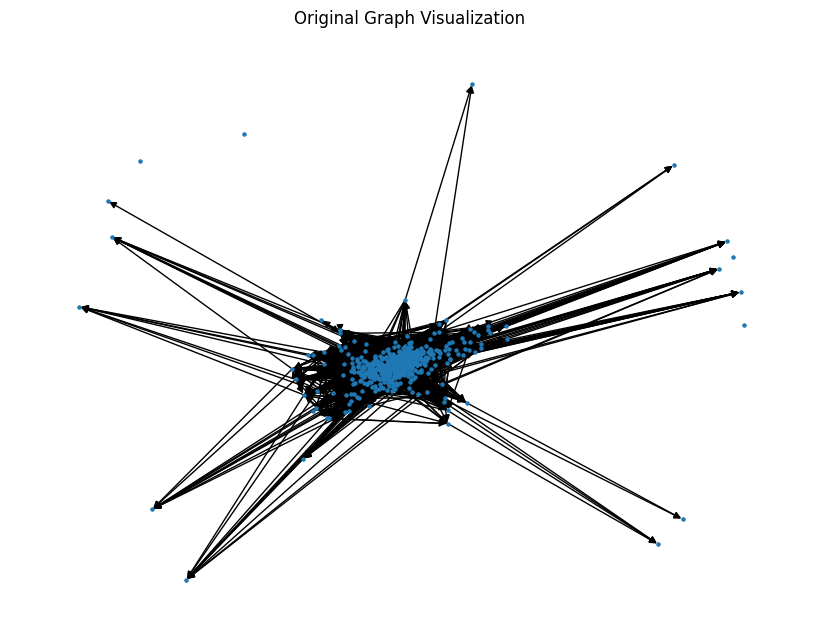

In [41]:
plt.figure(figsize=(8, 6))
nx.draw(G, node_size=5)
plt.title("Original Graph Visualization")
plt.show()

In [42]:
isolated_nodes = list(nx.isolates(G))
print("Isolated nodes:", isolated_nodes)

Isolated nodes: ['dr. hook & the medicine show', 'england dan & john ford coley', 'jet (australian band)', 'van zant (band)']


In [48]:
G.remove_nodes_from(isolated_nodes)
print("Number of nodes after removing isolated ones: ",G.number_of_nodes())

Number of nodes after removing isolated ones:  484


In [50]:
components = list(nx.weakly_connected_components(G))
largest_component = max(components, key=len)
G_largest = G.subgraph(largest_component).copy()
print("Number of nodes of largest component: ",G.number_of_nodes())

Number of nodes of largest component:  484


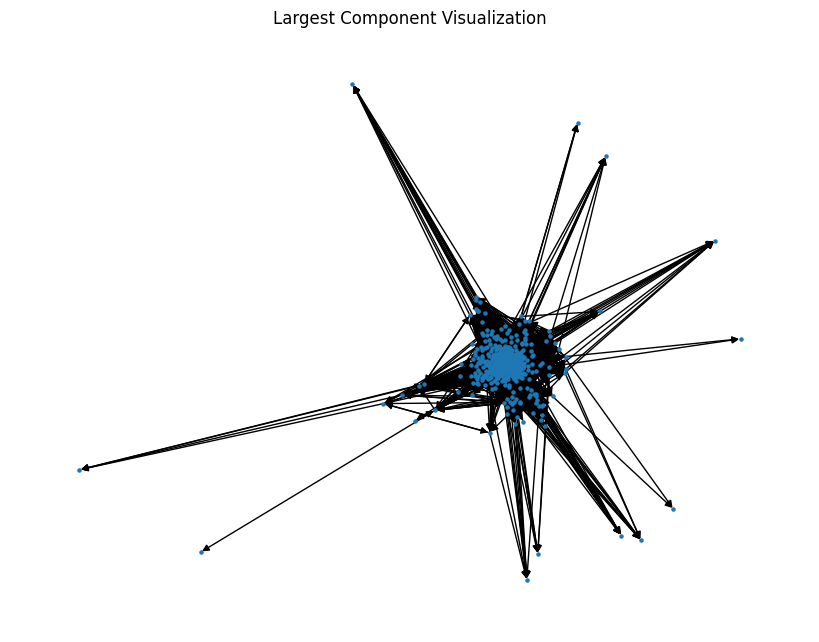

In [51]:
plt.figure(figsize=(8, 6))
nx.draw(G_largest, node_size=5)
plt.title("Largest Component Visualization")
plt.show()

## 2. Explain your process in words

### Explain your process in words

- **First, simply describe the steps of the process (what you did, step by step)**

The first step was to copy the content of the Wikipedia page https://en.wikipedia.org/wiki/List_of_mainstream_rock_performers to a text file, delete the markup that did not correspond to artists' names and extract all links using regular expressions. Some of these non-artist links were only found while doing the exercise and removed later. In the end, 488 artist links were found and saved in the *match_wiki* variable. 

Following this, for each artist found, we downloaded its Wikipedia page text using the Wikipedia API and saved it as an individual text file. A cleaned artist list was created (*match_wiki_clean*) where names like *10 Years (band)|10 Years* were reduced to *10 Years (band)* to be used to create the filename of the text file, which cannot contain special characters, and as the title of the wiki API query, since using 10 Years (band)|10 Years or 10 Years (band) redirects to the same page. At this point, we had to deal with two exceptions: the special character / had to be removed from *AC/DC*; and on *Shakin' Stevens* wikipedia page, the link to *The Rolling Stones* page was in lowercase. Therefore, we decided to work in lowercase and file names were saved in that format. For artist *Crosby, Stills, Nash & Young* the response from the API had a different structure from all the others and we could not extract its content. Since this was a unique situation, we decided to save its text file as an empty file.

Proceeding, the network was created by going through all the text files, one by one. For each text file, we created a node with the filename (artist name in lowercase), counted the number of words using regular expressions and saved that as an attribute named *length_of_content*. Then, all the links were extracted from the text file, using regular expressions once again, and filtered to extract the links that corresponded to artists of our original list. To execute this filtering, a list with all the artist names in lowercase and with *AC/DC* as *acdc* was created (*match_wiki_clean_lc*) and the links were also reformulated to deal with the *AC/DC* special case and to be shortened and converted to lowercase. We also did not allow multiple edges with the same direction between the same two artists and a node referencing itself. Within these restrictions, for each artist found, an edge between the file artist and the link artist was created. 

Lastly, the isolated nodes were identified and removed. The largest component of the network was extracted and resulted in the same number of nodes as the graph after removing its isolated nodes.

- **Then, write a short section about which part of the process that was most difficult**

The most difficult part of the process was dealing with the processing of the artist names at every stage. Initially, we had to generate proper filenames without special characters. For most artists, removing the | character and the text after it was sufficient but we still had to implement a special case for AC/DC to remove the / character. Later, when analyzing isolated nodes, we noticed that *Shakin' Stevens* had The Rolling Stone link in lowercase which was not recognized as an artist during filtering. To prevent the same issue in other pages, we decided to work in lowercase and had to modify the pipeline. Overall, we had to make changes multiple times to deal with special cases and ensure that when filtering all the lists had all artists' names formatted in the same way.


- **Next write a short section about how you used LLMs to help you**

LLMs were useful to understand and correct errors related to both the API query format and the API responses. The lecture from Week 1 provided us the basic structure for the workflow but some problems came up, as mentioned before with the artist *Crosby, Stills, Nash & Young* Wikipedia page, that required more specific guidance. While building the network, we also used LLMs to interpret and explain our code, without specifying its intended function. This approach helped us in identifying an unexpected behaviour or in confirming that it was functioning as intended. Additionally, we also used LLMs to suggest ways to visualize intermediate results so we could inspect and verify the middle steps.


- **Finally, compose a short section about what you would do differently if you had to do it again**

If we were to do this again, we would simplify the way we handled artist name formatting throughout all the stages. Our solution to this issue was built as different problems and issues arose, so we had to reformulate our approach multiple times and for very diverse problems. For example, instead of converting names to lowercase inside the loop when creating files and then generating a separate list with all lowercase entries, we could have started with an initial list already in lowercase.

## 3. Simple network statistics and analysis.

## 4. Let's build a simple visualization of the network

Build undirected graph.

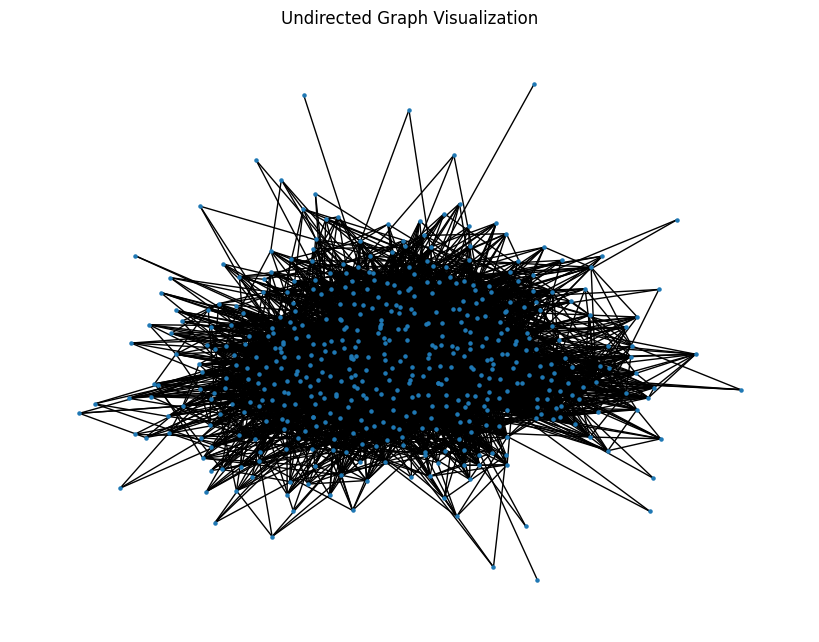

In [20]:
G_und=G_largest.to_undirected(reciprocal=False, as_view=False)

plt.figure(figsize=(8, 6))
nx.draw(G_und, node_size=5)
plt.title("Undirected Graph Visualization")
plt.show()

Spring force

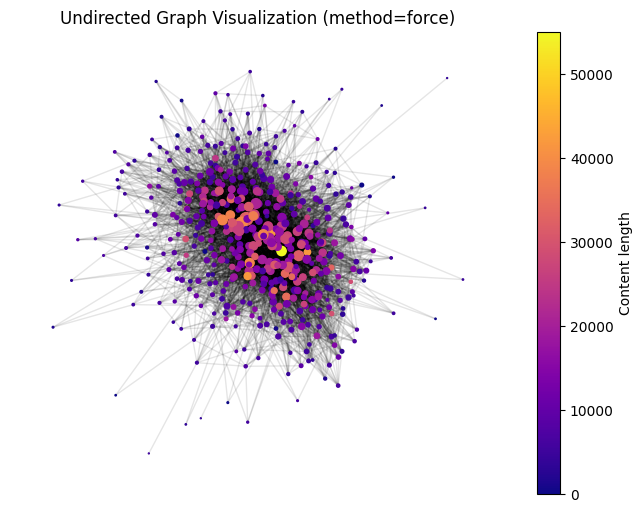

In [24]:
import matplotlib.pyplot as plt

pos_springf=nx.spring_layout(G_und, seed=42, method="force")

degrees_und=dict(G_und.degree())
node_sizes=np.array(list(degrees_und.values()))*0.5

att_und=nx.get_node_attributes(G_und, 'length_of_content')
node_colors=list(att_und.values())


plt.figure(figsize=(8, 6))
nodes=nx.draw_networkx_nodes(G_und, pos=pos_springf, node_size=node_sizes, node_color=node_colors,cmap=plt.cm.plasma)
nx.draw_networkx_edges(G_und, pos=pos_springf, alpha=0.1)

plt.colorbar(nodes, label="Content length")
plt.title("Undirected Graph Visualization (method=force)")
plt.axis("off")
plt.show()

Energy

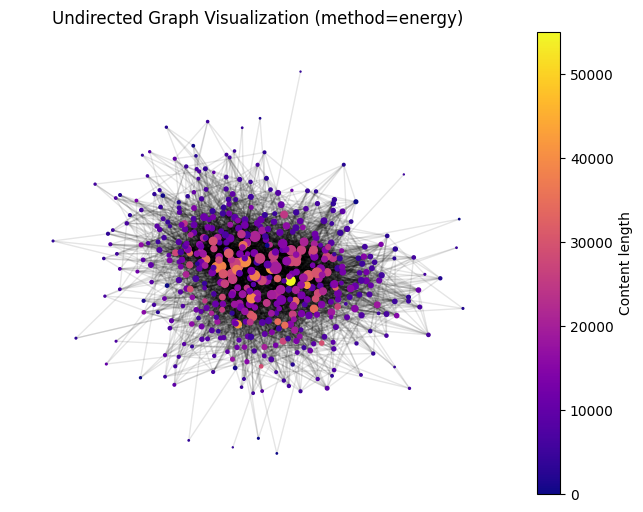

In [26]:
import matplotlib.pyplot as plt

pos_springe=nx.spring_layout(G_und, seed=42, method="energy")

degrees_und=dict(G_und.degree())
node_sizes=np.array(list(degrees_und.values()))*0.5

att_und=nx.get_node_attributes(G_und, 'length_of_content')
node_colors=list(att_und.values())

plt.figure(figsize=(8, 6))
nodes=nx.draw_networkx_nodes(G_und, pos=pos_springe, node_size=node_sizes, node_color=node_colors,cmap=plt.cm.plasma)
nx.draw_networkx_edges(G_und, pos=pos_springe, alpha=0.1)

plt.colorbar(nodes, label="Content length")
plt.title("Undirected Graph Visualization (method=energy)")
plt.axis("off")
plt.show()

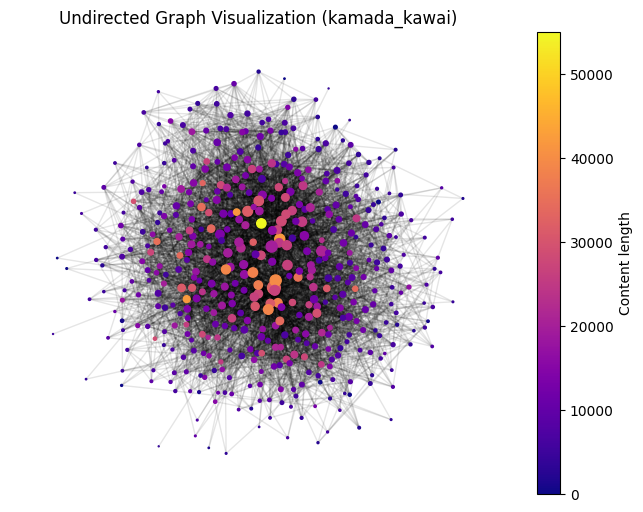

In [30]:
import matplotlib.pyplot as plt

pos_kamada=nx.kamada_kawai_layout(G_und)

degrees_und=dict(G_und.degree())
node_sizes=np.array(list(degrees_und.values()))*0.5

att_und=nx.get_node_attributes(G_und, 'length_of_content')
node_colors=list(att_und.values())

plt.figure(figsize=(8, 6))
nodes=nx.draw_networkx_nodes(G_und, pos=pos_kamada, node_size=node_sizes, node_color=node_colors,cmap=plt.cm.plasma)
nx.draw_networkx_edges(G_und, pos=pos_kamada, alpha=0.1)

plt.colorbar(nodes, label="Content length")
plt.title("Undirected Graph Visualization (kamada_kawai)")
plt.axis("off")
plt.show()

### **Notes on nodes**

Disconnected nodes:

- Dr hook: has no references on its wiki page of other artists
- England: redirect and no nodes coming in
- Jet: redirect and no nodes coming in
- Van zat: redirect and no nodes coming in